# NC Parcel Data Sanity Checks

Russell Blessing

## Load libraries

In [ ]:
library(sf)
library(dplyr)
library(ggplot2)
library(knitr)
library(DBI)
library(RSQLite)

## Point to directories and data

In [ ]:
# Output directory (external to repo; not tracked by git)
out_dir <- "/proj/mhinolab/users/rbless/data/Obstacles_Output"
dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)

out_gpkg <- file.path(out_dir, "parcels_study_area.gpkg")
out_csv  <- file.path(out_dir, "parcels_study_area.csv")

study_area_path <- "/proj/mhinolab/projects/obstacles/NC_huc6_data_union_sf/NC_huc6_data_union_sf.shp"
gpkg_path <- "/proj/mhinolab/users/rbless/data/parcels/NC_Parcels_all.gpkg"
parcels_layer <- "nc_parcels_poly" # update if st_layers() indicates otherwise

## Study Area

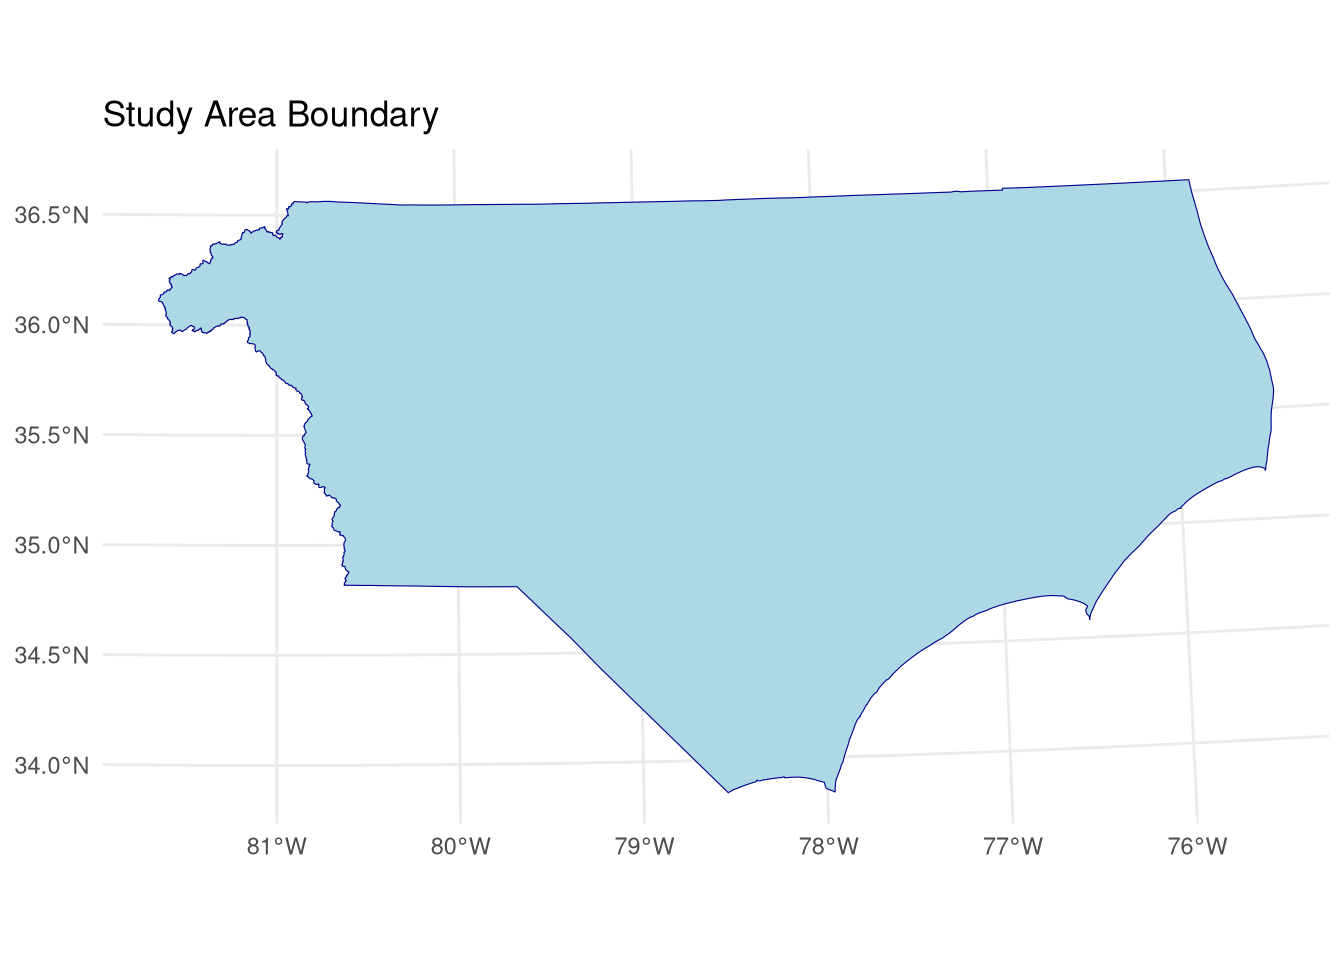

In [ ]:
study_area <- st_read(study_area_path, quiet = TRUE)

study_union <- study_area |>
st_make_valid() |>
st_union()

ggplot() +
geom_sf(data = study_union, fill = "lightblue", color = "darkblue") +
theme_minimal() +
labs(title = "Study Area Boundary")

## Identify parcel CRS

In [ ]:
get_layer_crs <- function(gpkg_path, layer) {
  sql <- sprintf('SELECT * FROM "%s" LIMIT 0', layer)
  x0 <- sf::st_read(gpkg_path, query = sql, quiet = TRUE)
  sf::st_crs(x0)
}

parcel_crs <- get_layer_crs(gpkg_path, parcels_layer)
parcel_crs$epsg   # should be 2264

## Parcels to Keep

-   cntyfips: The county FIPS code 3-digit
-   parno: The local parcel number for the parcel record
-   altparno: Alternative or local parcel number.
-   nparno: the local parcel number with the state and county FIPS added to the beginning of the local parcel number.
-   siteadd: the full site address as a single field
-   sunit:

In [ ]:
con <- dbConnect(RSQLite::SQLite(), gpkg_path)

# Get list of counties present (no geometry)
cntys <- dbGetQuery(
  con,
  sprintf('SELECT DISTINCT cntyfips FROM "%s"', parcels_layer)
)$cntyfips

cols_keep <- c("cntyfips","parno","altparno","nparno","siteadd","sunit","scity","szip",
               "mailadd","ownname","ownfrst","ownlast","parval","parusedesc")

dup_counts <- list()

cntys <- cntys[!is.na(cntys)]


for (c in cntys) {
  sql <- sprintf('SELECT %s FROM "%s" WHERE cntyfips = %s',
                 paste(sprintf('"%s"', cols_keep), collapse=", "),
                 parcels_layer, c)

  x <- st_read(gpkg_path, query = sql, quiet = TRUE) |> st_drop_geometry()

  dup_counts[[as.character(c)]] <- x |>
    count(cntyfips, parno) |>
    filter(n > 1)
}

dup_counts <- bind_rows(dup_counts)
dup_counts

dup_path <- file.path(out_dir, "dup_counts_cntyfips_parno.rds")
saveRDS(dup_counts_cntyfips_parno, dup_path)

In [ ]:
dup_counts <- readRDS("/proj/mhinolab/users/rbless/data/Obstacles_Output/dup_counts_cntyfips_parno.rds")